In [1]:
import tensorflow as tf
import cv2

print("TensorFlow Version:", tf.__version__)
print("OpenCV Version:", cv2.__version__)

TensorFlow Version: 2.17.1
OpenCV Version: 4.10.0


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-mask-12k-images-dataset


In [3]:
import os

dataset_path = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset"
print(os.listdir(dataset_path))

['Validation', 'Test', 'Train']


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [5]:
# Define dataset paths
dataset_path = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset"
train_dir = os.path.join(dataset_path, "Train")
test_dir = os.path.join(dataset_path, "Test")
val_dir = os.path.join(dataset_path, "Validation")

# Define categories
categories = ["WithMask", "WithoutMask"]

# Function to get image paths
def get_image_paths(directory):
    image_paths = []
    labels = []
    
    for category in categories:
        category_path = os.path.join(directory, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            image_paths.append(img_path)
            labels.append(category)  # Label as folder name
    
    return image_paths, labels

# Load all image paths
train_paths, train_labels = get_image_paths(train_dir)
val_paths, val_labels = get_image_paths(val_dir)
test_paths, test_labels = get_image_paths(test_dir)

# Print dataset size
print(f"Train: {len(train_paths)}, Validation: {len(val_paths)}, Test: {len(test_paths)}")

Train: 10000, Validation: 800, Test: 992


In [6]:
# Define image size
IMG_SIZE = 128

# Function to load, resize, and preprocess images
def load_and_preprocess_images(image_paths, labels):
    X = []
    y = []

    for img_path, label in zip(image_paths, labels):
        image = cv2.imread(img_path)  # Load image
        if image is None:
            continue  # Skip corrupt images
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)  # Resize

        X.append(image)
        y.append(0 if label == "WithMask" else 1)  # Encode labels (0: WithMask, 1: WithoutMask)
    
    return np.array(X), np.array(y)

# Load datasets
X_train, y_train = load_and_preprocess_images(train_paths, train_labels)
X_val, y_val = load_and_preprocess_images(val_paths, val_labels)
X_test, y_test = load_and_preprocess_images(test_paths, test_labels)

# Print final dataset shapes
print(f"Training Data Shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation Data Shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Testing Data Shape: {X_test.shape}, Labels: {y_test.shape}")

Training Data Shape: (10000, 128, 128, 3), Labels: (10000,)
Validation Data Shape: (800, 128, 128, 3), Labels: (800,)
Testing Data Shape: (992, 128, 128, 3), Labels: (992,)


In [7]:
# Normalize images to range [0,1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Convert labels to categorical format for neural networks
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print("Normalization & Label Encoding Done!")

Normalization & Label Encoding Done!


In [8]:
# Define Image Data Generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation (0-20 degrees)
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images
    fill_mode='nearest'  # Fill in missing pixels
)

# Apply augmentation only to training data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

print("Augmentation Done!")

Augmentation Done!


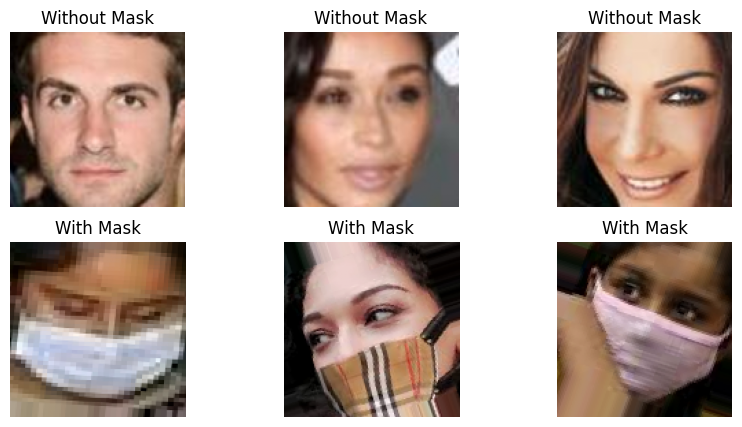

In [9]:
# Select 3 images from "With Mask" and 3 from "Without Mask"
with_mask_indices = np.where(np.argmax(y_train, axis=1) == 0)[0]  # Indices for With Mask
without_mask_indices = np.where(np.argmax(y_train, axis=1) == 1)[0]  # Indices for Without Mask

# Randomly sample 3 images from each category
sample_with_mask = np.random.choice(with_mask_indices, 3, replace=False)
sample_without_mask = np.random.choice(without_mask_indices, 3, replace=False)

# Combine both samples
sample_indices = np.concatenate((sample_with_mask, sample_without_mask))
np.random.shuffle(sample_indices)  # Shuffle for randomness

# Display selected images
plt.figure(figsize=(10, 5))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[idx])  # Display the image
    plt.title("With Mask" if np.argmax(y_train[idx]) == 0 else "Without Mask")
    plt.axis("off")

plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.8549 - loss: 0.3472 - val_accuracy: 0.9663 - val_loss: 0.1209
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - accuracy: 0.9241 - loss: 0.2162 - val_accuracy: 0.9413 - val_loss: 0.1434
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - accuracy: 0.9440 - loss: 0.1618 - val_accuracy: 0.9688 - val_loss: 0.1213
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.9382 - loss: 0.1744 - val_accuracy: 0.9712 - val_loss: 0.1062
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.9487 - loss: 0.1550 - val_accuracy: 0.9700 - val_loss: 0.0775
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.9548 - loss: 0.1335 - val_accuracy: 0.9750 - val_loss: 0.0718
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.9624 - loss: 0.1074 - val_accuracy: 0.9825 - val_loss: 0.0656
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.9666 - loss: 0.0983 - val

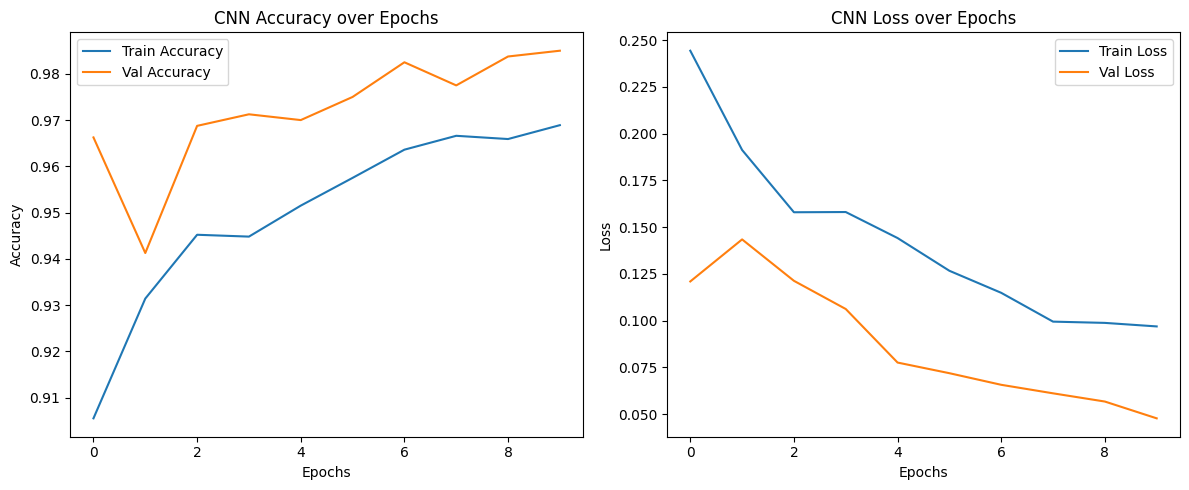

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
📄 CNN Classification Report:
              precision    recall  f1-score   support

    WithMask       0.98      0.98      0.98       483
 WithoutMask       0.98      0.98      0.98       509

    accuracy                           0.98       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.98      0.98      0.98       992



In [10]:
# CNN model
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_cnn = model_cnn.fit(train_generator, epochs=10, validation_data=(X_val, y_val))

# Plot Accuracy and Loss curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('CNN Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_true_cnn = np.argmax(y_test, axis=1)

# Classification Report
print("📄 CNN Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn_classes, target_names=['WithMask', 'WithoutMask']))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.9633 - loss: 0.0905 - val_accuracy: 0.9950 - val_loss: 0.0156
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - accuracy: 0.9874 - loss: 0.0335 - val_accuracy: 0.9887 - val_loss: 0.0261
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.9894 - loss: 0.0263 - val_accuracy: 0.9975 - val_loss: 0.0052
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.9895 - loss: 0.0273 - val_accuracy: 0.9962 - val_loss: 0.0068
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.9930 - loss: 0.0160 - val_accuracy: 0.9975 - val_loss: 0.0071
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - accuracy: 0.9930 - loss: 0.0183 - val_accuracy: 0.9937 - val_loss: 0.0147
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - accuracy: 0.9940 - loss: 0.0183 - val_accuracy: 0.9975 - val_loss: 0.0058
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━

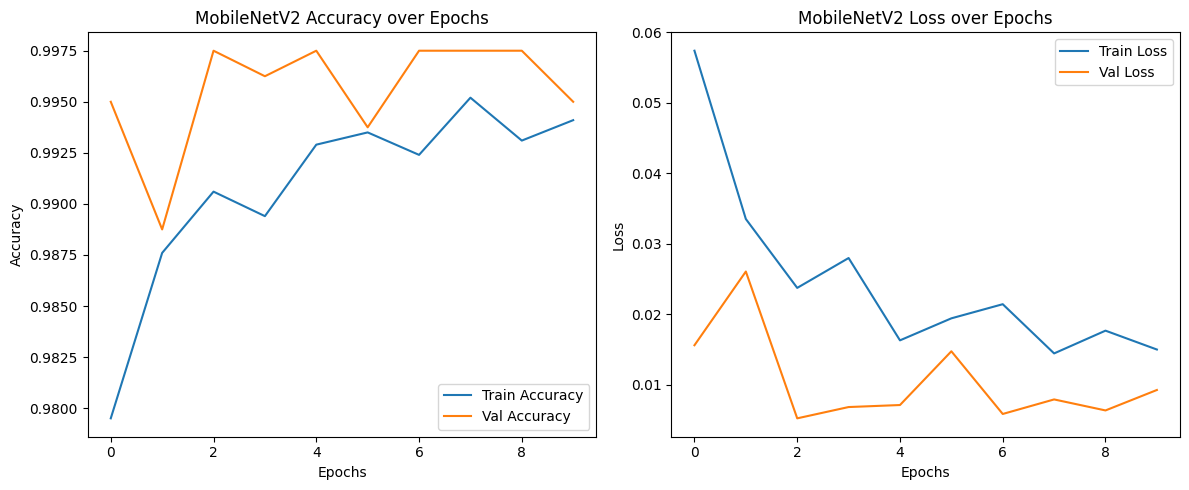

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
📄 MobileNetV2 Classification Report:
              precision    recall  f1-score   support

    WithMask       0.99      1.00      0.99       483
 WithoutMask       1.00      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



In [11]:
# Transfer Learning with MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model_mobilenet = Model(inputs=base_model.input, outputs=output)
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_mobilenet = model_mobilenet.fit(train_generator, epochs=10, validation_data=(X_val, y_val))

# Plot Accuracy and Loss curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2 Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Val Loss')
plt.title('MobileNetV2 Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred_mobilenet = model_mobilenet.predict(X_test)
y_pred_mobilenet_classes = np.argmax(y_pred_mobilenet, axis=1)
y_true_mobilenet = np.argmax(y_test, axis=1)

# Classification Report
print("📄 MobileNetV2 Classification Report:")
print(classification_report(y_true_mobilenet, y_pred_mobilenet_classes, target_names=['WithMask', 'WithoutMask']))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - accuracy: 0.5418 - loss: 0.7004 - val_accuracy: 0.6275 - val_loss: 0.6459
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.6125 - loss: 0.6546 - val_accuracy: 0.5950 - val_loss: 0.6548
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.6244 - loss: 0.6435 - val_accuracy: 0.7113 - val_loss: 0.6125
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.6490 - loss: 0.6300 - val_accuracy: 0.6513 - val_loss: 0.5876
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.6517 - loss: 0.6255 - val_accuracy: 0.7013 - val_loss: 0.5623
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.6671 - loss: 0.6114 - val_accuracy: 0.6375 - val_loss: 0.5802
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.6669 - loss: 0.6082 - val_accuracy: 0.7750 - val_loss: 0.5457
Epoch 8/10
313/313 ━━━━━━━━━━━━━

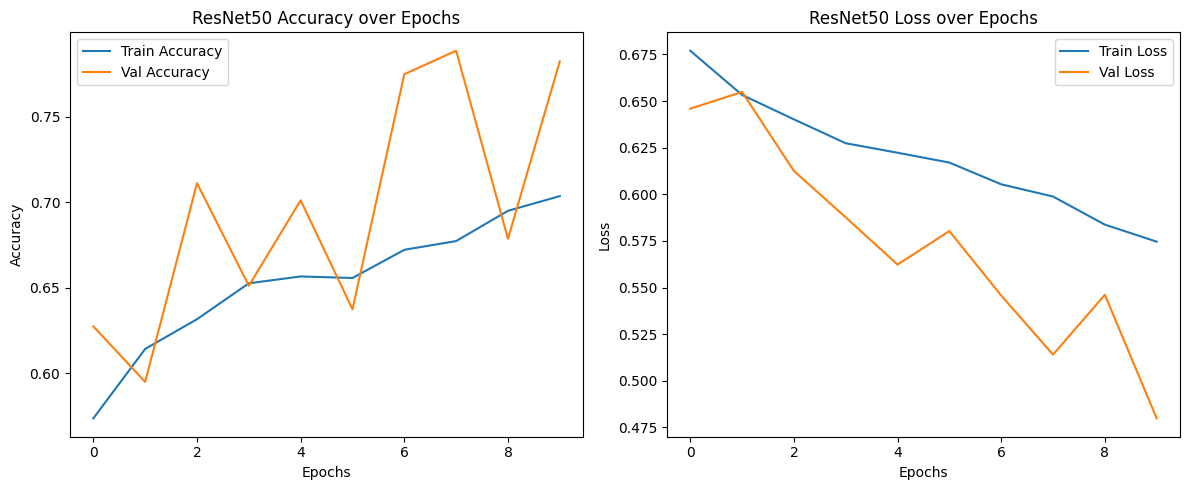

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
📄 ResNet50 Classification Report:
              precision    recall  f1-score   support

    WithMask       0.87      0.75      0.81       483
 WithoutMask       0.79      0.89      0.84       509

    accuracy                           0.82       992
   macro avg       0.83      0.82      0.82       992
weighted avg       0.83      0.82      0.82       992



In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report

# Load base ResNet50 (exclude top)
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_resnet.trainable = False  # Freeze pretrained layers

# Add classification head
x = base_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model_resnet = Model(inputs=base_resnet.input, outputs=output)

# Compile
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_resnet = model_resnet.fit(train_generator, epochs=10, validation_data=(X_val, y_val))

# Plot Accuracy and Loss curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet50 Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title('ResNet50 Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred_resnet = model_resnet.predict(X_test)
y_pred_resnet_classes = np.argmax(y_pred_resnet, axis=1)
y_true_resnet = np.argmax(y_test, axis=1)

# Classification Report
print("📄 ResNet50 Classification Report:")
print(classification_report(y_true_resnet, y_pred_resnet_classes, target_names=['WithMask', 'WithoutMask']))

In [13]:
def get_softmax_preds(model, X):
    return model.predict(X)

# Collect base model predictions
cnn_train = get_softmax_preds(model_cnn, X_train)
mobilenet_train = get_softmax_preds(model_mobilenet, X_train)
resnet_train = get_softmax_preds(model_resnet, X_train)

cnn_val = get_softmax_preds(model_cnn, X_val)
mobilenet_val = get_softmax_preds(model_mobilenet, X_val)
resnet_val = get_softmax_preds(model_resnet, X_val)

cnn_test = get_softmax_preds(model_cnn, X_test)
mobilenet_test = get_softmax_preds(model_mobilenet, X_test)
resnet_test = get_softmax_preds(model_resnet, X_test)

# Stack predictions (axis=1)
X_train_stack = np.concatenate([cnn_train, mobilenet_train, resnet_train], axis=1)
X_val_stack = np.concatenate([cnn_val, mobilenet_val, resnet_val], axis=1)
X_test_stack = np.concatenate([cnn_test, mobilenet_test, resnet_test], axis=1)

# Use original labels
y_train_stack = np.argmax(y_train, axis=1)
y_val_stack = np.argmax(y_val, axis=1)
y_test_stack = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9347 - loss: 0.2869 - val_accuracy: 0.9975 - val_loss: 0.0276
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0204 - val_accuracy: 0.9975 - val_loss: 0.0119
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9980 - loss: 0.0127 - val_accuracy: 0.9975 - val_loss: 0.0089
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9986 - loss: 0.0066 - val_accuracy: 0.9975 - val_loss: 0.0078
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9988 - loss: 0.0062 - val_accuracy: 0.9975 - val_loss: 0.0072
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9983 - loss: 0.0070 - val_accuracy: 0.9975 - val_loss: 0.0068
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9988 - loss: 0.0061 - val_accuracy: 0.9975 - val_loss: 0.0066
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0065 - val_accuracy: 0.9975 - val_

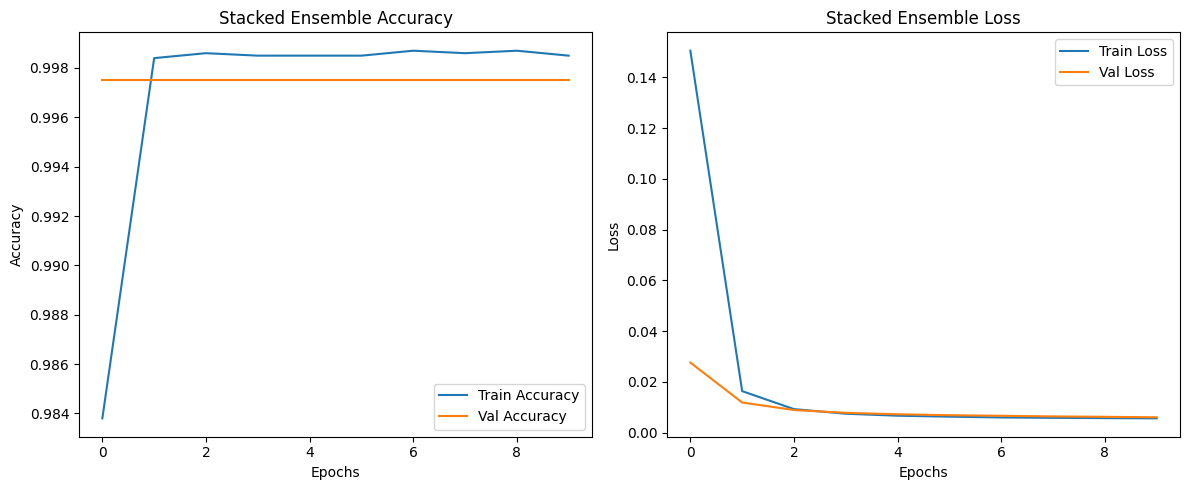

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
📄 Stacked Ensemble Classification Report:
              precision    recall  f1-score   support

    WithMask       0.99      1.00      0.99       483
 WithoutMask       1.00      0.99      1.00       509

    accuracy                           0.99       992
   macro avg       0.99      1.00      0.99       992
weighted avg       0.99      0.99      0.99       992



In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Convert labels for softmax
y_train_cat = to_categorical(y_train_stack, num_classes=2)
y_val_cat = to_categorical(y_val_stack, num_classes=2)
y_test_cat = to_categorical(y_test_stack, num_classes=2)

# Build meta-classifier
meta_model = Sequential([
    Dense(16, activation='relu', input_shape=(6,)),
    Dense(2, activation='softmax')
])

meta_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_meta = meta_model.fit(X_train_stack, y_train_cat, epochs=10, validation_data=(X_val_stack, y_val_cat))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_meta.history['accuracy'], label='Train Accuracy')
plt.plot(history_meta.history['val_accuracy'], label='Val Accuracy')
plt.title('Stacked Ensemble Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_meta.history['loss'], label='Train Loss')
plt.plot(history_meta.history['val_loss'], label='Val Loss')
plt.title('Stacked Ensemble Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

y_pred_meta = meta_model.predict(X_test_stack)
y_pred_meta_classes = np.argmax(y_pred_meta, axis=1)

print("📄 Stacked Ensemble Classification Report:")
print(classification_report(y_test_stack, y_pred_meta_classes, target_names=['WithMask', 'WithoutMask']))

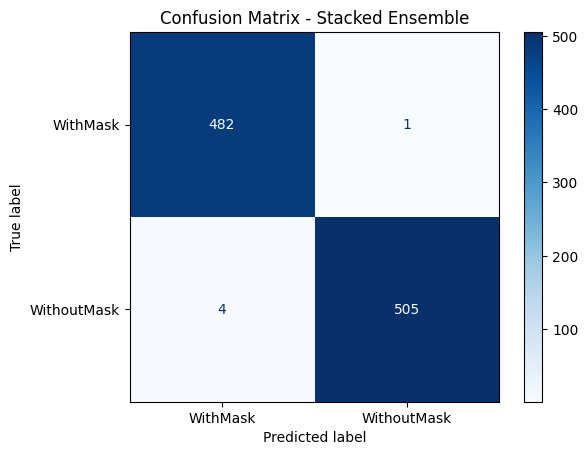

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test_stack, y_pred_meta_classes)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['WithMask', 'WithoutMask'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Stacked Ensemble")
plt.show()